In [1]:
from utils.ModelWrapper import ModelWrapper, ModelType
import tensorflow as tf
from tensorflow.keras.models import load_model
import wandb
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
# Init
wandb_project_name = 'deepfake-basic'
data_dir = "./data/data-large/data"
img_size = 128
wandb.init(project=wandb_project_name, entity="dat550")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dat550 (use `wandb login --relogin` to force relogin)


### Wandb Sweep training of the model

In [3]:
def train():
   # Default values for hyper-parameters we are going to sweep over
   config_defaults = {
         'epochs': 1,
         'batch_size': 32,
         'learning_rate': 0.0001,
         'optimizer': 'adam',
         'hidden_layer_size': 64,
         'conv_layer_1_size': 16,
         'conv_layer_2_size': 32,
         'conv_layer_3_size': 64,
         'dropout': 0.5,
         "use_augmentation": True,
      }
   # Initialize wandb with a sample project name
   wandb.init(config=config_defaults, project=wandb_project_name, entity="dat550")

   # # Config is a variable that holds and saves hyperparameters and inputs
   config = wandb.config

   # init wrapper
   modeltype = ModelType.CNN
   model_wrapper = ModelWrapper(data_dir, img_size, config, modeltype=modeltype,use_wandb=False, use_generator=False, sample_datasets=True)

   # Define the optimizer
   if config.optimizer=='sgd':
      optimizer = tf.keras.optimizers.SGD(learning_rate=config.learning_rate) 
   elif config.optimizer=='rmsprop':
      optimizer = tf.keras.optimizers.RMSprop(learning_rate=config.learning_rate,)
   elif config.optimizer=='adam':
      optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate,) 
   elif config.optimizer=='nadam':
      optimizer = tf.keras.optimizers.Nadam(learning_rate=config.learning_rate,) 
   
   # Compile the model
   model_wrapper.model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['accuracy'])
   # Train the model
   model_wrapper.fit()
   return model_wrapper

In [4]:
# sweep training
sweep_config = {
    "name": "deepfake-basic-sweep",
   'method': 'bayes',
    "metric": {
            "name": "accuracy",
            "goal": "maximize"
        },
    "early_terminate": {
       "type": "hyperband",
       "min_iter": 5
   },
   'parameters': {
        'batch_size': {
            'values': [64, 128, 256] 
        },
        'dropout': {
            'values': [0.0, 0.2, 0.5]
        },
        'conv_layer_1_size': {
            'values': [16,32], #32
        },
        'conv_layer_2_size': {
            'values': [32,64] #64
        },
        'conv_layer_3_size': {
            'values': [64 ,128] # 128
        },
        'hidden_layer_size': {
                'values': [64, 128] 
            },
      'learning_rate': {
            'values': [1e-2, 1e-3, 1e-4, 3e-4]
        },
        'optimizer': {
            'values': ['adam',  "nadam", 'sgd', 'rmsprop']
        },
          "use_augmentation": {
            "values": [False, True] 
        }
   }
}

In [5]:
USE_SWEEP = False
if USE_SWEEP:
    sweep_id = wandb.sweep(sweep_config, project=wandb_project_name, entity="dat550")
    wandb.agent(sweep_id, function=train)
else:
    model_wrapper = train()

Found 29988 files belonging to 2 classes.
Using 5997 files for validation.
Found 3431 files belonging to 2 classes.
Using 686 files for validation.
Found 1587 files belonging to 2 classes.
188/188 [==============================] - 59s 294ms/step - loss: 2.7939 - accuracy: 0.5121 - val_loss: 0.6930 - val_accuracy: 0.5262


### Evaluate model

In [6]:
eval_wandb_model = False
if eval_wandb_model:
    # load the bess model NB: edit namd and path
    loaded_model = wandb.restore('model-best.h5', run_path="dat550/deepfake-efficientnet/runs/29425ckm")
    model_to_eval = load_model(loaded_model.name)
elif model_wrapper != None:
    model_to_eval = model_wrapper.model
else:
    raise Exception("No model to evaluate")

50/50 [==============================] - 4s 75ms/step
self.test_data.file_paths:  1587
preds:  1587
conf_matrix: 
 [[  0   0]
 [777 810]]


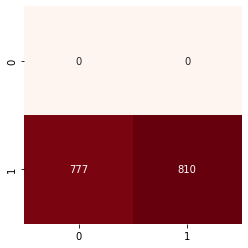

In [7]:
model_wrapper.evaluate_model(model_to_eval)

In [8]:
model_wrapper.export_to_png()